In [1]:
import pandas as pd

train=pd.read_csv("trainingandtestdata/training.csv",encoding='latin-1')
#with open("trainingandtestdata/training.csv", encoding='latin-1') as f:
 #   dt=f.read()
train.columns=["label","id","date","query","user","sentence"]
train=train[["label","sentence"]]
#preprocess
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
sentence_list=[]
for st in train.sentence:
    st_list=tokenizer.tokenize(st)
    sentence_list.append(st_list)
label_list=train["label"].tolist()

df=train
df["sentence"]=sentence_list

In [2]:
df.head()

,label,sentence
0,0,"[is, upset, that, he, can, t, update, his, Fac..."
1,0,"[Kenichan, I, dived, many, times, for, the, ba..."
2,0,"[my, whole, body, feels, itchy, and, like, its..."
3,0,"[nationwideclass, no, it, s, not, behaving, at..."
4,0,"[Kwesidei, not, the, whole, crew]"


import gensim

# Load Google's pre-trained Word2Vec model.
#model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  
model_e=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  



df.label.value_counts()

In [10]:
df=df.sample(frac=0.01, replace=False)

In [11]:
# --- Preparing the Data ---
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np
maxlen=40

sentence_num=[]
for st in df["sentence"].tolist():
    single_sentence=[]
    for w in st:
        try:
            single_sentence.append(model_e[w])
        except:
            single_sentence.append(model_e["UNK"])
    
    single_sentence=sequence.pad_sequences(np.array(single_sentence).T, maxlen = maxlen)
    
    single_sentence=single_sentence.T
        
    sentence_num.append(single_sentence)

np.array(single_sentence).shape

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(40, 300)

### Model

In [13]:
import pandas as pd
import numpy as np
# --- Libraries ---
# - Base libs - 
import os
import numpy as np

# -Tensorflow-
import tensorflow as tf
from tensorflow.python.client import device_lib
# -Keras libs-
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint


# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

### KEEP the original data

In [4]:
import numpy as np
df=train
df.loc[df["label"]==4,"label"]=1

df["sentence"]=sentence_list
df=df.sample(frac=0.01, replace=False)
from nltk.corpus import wordnet

#word dictionary
word_list=[]
sentences=df["sentence"].tolist()
for sentence in sentences:
    for word in sentence:
        # if wordnet.synsets(word.lower()):
            if word not in word_list:
                word_list.append(word.lower())


            
        


In [6]:
#how many words in a single sentence
max_len = 75
#maximum length of the word: how many characters a word contain
max_len_char = 10

words=word_list
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}


### Word characters 

In [7]:
from keras.preprocessing.sequence import pad_sequences
sentences=df.sentence
X_word=[]
for s in sentences:
    single_s=[]
    for w in s:
       # if wordnet.synsets(w.lower()):
            single_s.append(word2idx[w.lower()])
        #else:
         #   single_s.append(word2idx["UNK"])
    X_word.append(single_s)
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
X_word.shape

C:\Users\nikhi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(16000, 75)

In [8]:
chars = set([w_i for sentence in df.sentence for w in sentence for w_i in w])
n_chars = len(chars)
print(n_chars)

char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0


X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


93


In [9]:
y=df.label
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [10]:
## Define the character embedding model
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D,Flatten, Conv2D,MaxPooling1D,MaxPooling2D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


model = Sequential()
model.add(Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True))
#model.add(SimpleRNN(12))
#model.add(GRU(32))
model.add(LSTM(5))
model.add(Dense(1, activation ='sigmoid'))
model.summary()

###CHARSCNN

In [30]:
# input and embedding for words
n_words=len(words)

# define the model
model = Sequential()
#model.add(Embedding(n_words, 8, input_length=max_len))

word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=False)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=False))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                               recurrent_dropout=0.5))(emb_char)

# main CNN
x = concatenate([emb_word, char_enc],axis=1)
x = SpatialDropout1D(0.3)(x)
#x=Flatten()(x)
# main model
                                
# first feature extractor
conv1 = Conv1D(8, kernel_size=4, activation='relu')(x)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flat1 = Flatten()(pool1)
# prediction output
output = Dense(1, activation='sigmoid')(flat1)
model = Model(inputs=[word_in, char_in], outputs=output)


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 75, 10, 10)   950         input_10[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 75, 20)       1064520     input_9[0][0]                    
__________________________________________________________________________________________________
time_distr

In [31]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])


In [32]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr),
                    batch_size=32, epochs=10, validation_split=0.2, verbose=1)


Train on 11520 samples, validate on 2880 samples
Epoch 1/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.6902 - acc: 0.5313 - val_loss: 0.6784 - val_acc: 0.5851
Epoch 2/10
11520/11520 [==============================] - 32s 3ms/step - loss: 0.5873 - acc: 0.7028 - val_loss: 0.5681 - val_acc: 0.7219
Epoch 3/10
11520/11520 [==============================] - 32s 3ms/step - loss: 0.4073 - acc: 0.8317 - val_loss: 0.5518 - val_acc: 0.7403
Epoch 4/10
11520/11520 [==============================] - 33s 3ms/step - loss: 0.2666 - acc: 0.9054 - val_loss: 0.5904 - val_acc: 0.7260
Epoch 5/10
11520/11520 [==============================] - 31s 3ms/step - loss: 0.1706 - acc: 0.9434 - val_loss: 0.6361 - val_acc: 0.7247
Epoch 6/10
11520/11520 [==============================] - 31s 3ms/step - loss: 0.1113 - acc: 0.9661 - val_loss: 0.7005 - val_acc: 0.7167
Epoch 7/10
11520/11520 [==============================] - 31s 3ms/step - loss: 0.0767 - acc: 0.9772 - val_loss: 0.7759 - val_acc:

In [33]:
model.evaluate([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te))

1600/1600 [==============================] - 1s 638us/step


[1.0790608841180802, 0.68375]

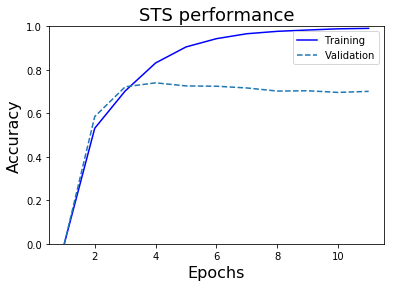

In [50]:
# --- Plotting data/training model ---
import matplotlib.pyplot as plt

# Get loss function
loss = history.history['acc']
loss=[0]+list(loss)
val_loss = history.history['val_acc']
val_loss=[0]+list(val_loss)

# Setup grid for plotting
epochs =range(1, len(loss) + 1)
#epochs=[0]+list(epochs)
# Plot
plt.close("all")
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss,'--', label='Validation')
plt.ylim(0,1)
plt.title('STS performance',fontsize=18)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.savefig("accuray.png")
plt.show()

### backup

 --- Preparing the Data ---
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np
maxlen=40

sentence_num=[]
for st in df["sentence"].tolist():
    single_sentence=[]
    for w in st:
        single_sentence.append(vocab[w])
       
    #single_sentence=sequence.pad_sequences(np.array(single_sentence).T, maxlen = maxlen)
    
    #single_sentence=single_sentence.T
        
    sentence_num.append(single_sentence)



print('Pad sequence (sample x time)')
input_all = sequence.pad_sequences(sentence_num, maxlen = maxlen)
input_all.shape

#split to train and test data
import random
samples=range(len(input_all))
num_train=int(len(input_all)*0.7)
train_index=random.sample(samples,num_train)
test_index=[i for i in samples if i not in train_index]
input_train=input_all[train_index]
input_test=input_all[test_index]



y_train=df["label"].values[train_index]
y_test=df["label"].values[test_index]

max_features=100000

model = Sequential()
model.add(Embedding(max_features, 300))
#model.add(SimpleRNN(12))
#model.add(GRU(32))
model.add(LSTM(5))
model.add(Dense(1, activation ='sigmoid'))
model.summary()

#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])


# Verbose=0 -> to avoid jupyter notebook freezing
history = model.fit(input_train, y_train, 
                    epochs = 5, batch_size = 32, 
                    verbose=1)

model.evaluate(input_test,y_test)